In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check data shape
for images, _ in train_loader:
    print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
    break

Batch shape: torch.Size([32, 1, 28, 28])


In [4]:
class RBM(torch.nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, lr=0.01):
        super(RBM, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(visible_dim, hidden_dim) * 0.01)
        self.a = torch.nn.Parameter(torch.zeros(visible_dim))  # Visible bias
        self.b = torch.nn.Parameter(torch.zeros(hidden_dim))   # Hidden bias
        self.lr = lr

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def sample_hidden(self, v):
        h_probs = self.sigmoid(torch.matmul(v, self.W) + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = self.sigmoid(torch.matmul(h, self.W.t()) + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def contrastive_divergence(self, v0, k=1):
        # Positive phase
        h0_probs, h0_sample = self.sample_hidden(v0)

        # Negative phase (k-step Gibbs sampling)
        vk = v0.clone()
        for _ in range(k):
            _, hk_sample = self.sample_hidden(vk)
            vk_probs, vk_sample = self.sample_visible(hk_sample)
            vk = vk_sample

        # Update parameters
        positive_association = torch.matmul(v0.t(), h0_probs)
        negative_association = torch.matmul(vk.t(), self.sigmoid(torch.matmul(vk, self.W) + self.b))

        self.W.data += self.lr * (positive_association - negative_association) / v0.size(0)
        self.a.data += self.lr * (v0.mean(dim=0) - vk.mean(dim=0))
        self.b.data += self.lr * (h0_probs.mean(dim=0) - self.sigmoid(torch.matmul(vk, self.W) + self.b).mean(dim=0))

In [5]:
# Initialize RBM
visible_dim = 784  # 28x28 images
hidden_dim = 128
rbm = RBM(visible_dim, hidden_dim, lr=0.01)

# Training parameters
epochs = 10

# Train
for epoch in range(epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Flatten images and binarize
        data = data.view(-1, visible_dim)
        data = (data > 0.5).float()  # Binarize

        # Perform contrastive divergence
        rbm.contrastive_divergence(data)

        # Calculate reconstruction error
        h_probs, _ = rbm.sample_hidden(data)
        v_probs, _ = rbm.sample_visible(h_probs)
        loss = torch.mean((data - v_probs) ** 2)
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.0628
Epoch 2/10, Loss: 0.0449
Epoch 3/10, Loss: 0.0389
Epoch 4/10, Loss: 0.0353
Epoch 5/10, Loss: 0.0329
Epoch 6/10, Loss: 0.0310
Epoch 7/10, Loss: 0.0295
Epoch 8/10, Loss: 0.0283
Epoch 9/10, Loss: 0.0272
Epoch 10/10, Loss: 0.0263


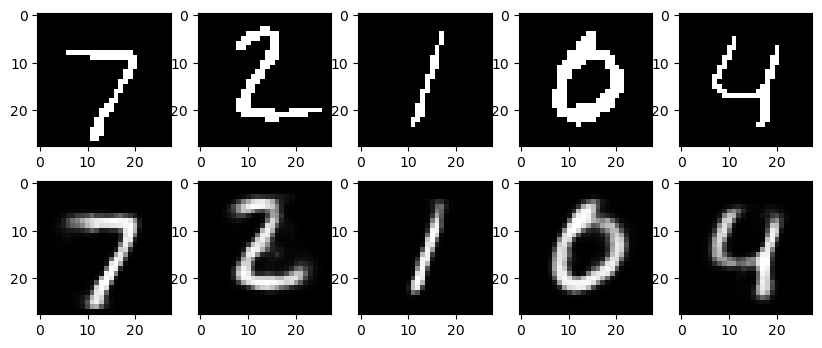

In [13]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, data_loader, num=5):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.view(-1, visible_dim)
            images = (images > 0.5).float()  # Binarize

            # Reconstruct
            h_probs, _ = model.sample_hidden(images)
            v_probs, _ = model.sample_visible(h_probs)

            # Plot
            plt.figure(figsize=(10, 4))
            for i in range(num):
                # Original
                ax = plt.subplot(2, num, i+1)
                plt.imshow(images[i].reshape(28, 28), cmap='gray')

                # Reconstructed
                ax = plt.subplot(2, num, num+i+1)
                plt.imshow(v_probs[i].reshape(28, 28), cmap='gray')
            plt.show()
            break

plot_reconstructions(rbm, test_loader)

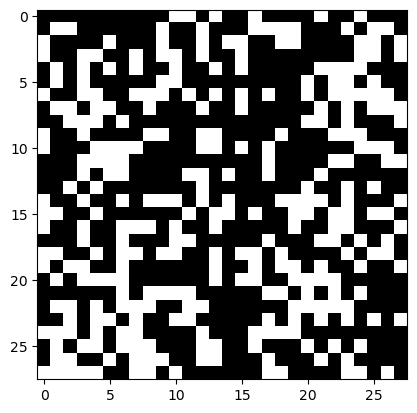

In [12]:
# sampling from random noise:

def generate_samples(model, num_samples=10, gibbs_steps=1000):
    # Disable gradient tracking
    with torch.no_grad():
        # Start with random visible units
        v = torch.bernoulli(torch.rand(num_samples, 784)).float()

        # Run Gibbs sampling
        for _ in range(gibbs_steps):
            _, h = model.sample_hidden(v)
            _, v = model.sample_visible(h)

        # Detach and convert to NumPy
        return v.detach().cpu().numpy()

# Usage with proper visualization
samples = generate_samples(rbm)
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.show()